# Intro

Our quantized MLP looks like the following:

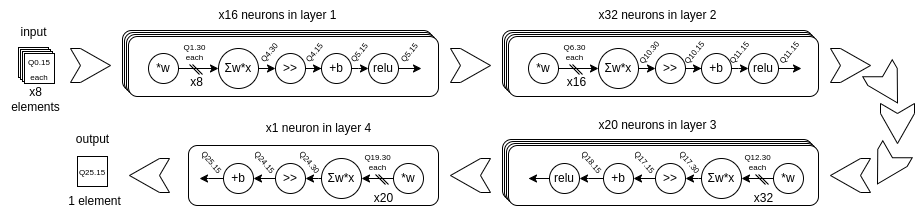

We will do the following in order:
- train the MLP with floating point numbers (inputs - outputs normalized to [-1,+1])
- analyze its layer outputs and overall network performance (train-test loss)
- instantiate a quantized version that uses quantized versions of the trained float model parameters  
- analyze the performance of the quantized model (in python)
- extract quantized parameters in VHDL-friendly format (ready for copy-paste)

        after this, switch to Vivado and paste the weights into arrays

- write test samples (1x8 vectors) into text files in VHDL-friendly format (for our Vivado testbench)

        after this, switch back to Vivado and run the testbench

- cross-check results from testbench against python

# Training float model

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import math
import random

In [ ]:
# to get reproducible outputs every time
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [ ]:
ds = fetch_california_housing(); x  = ds.data; y  = ds.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print("Training inputs:", x_train.shape, ", Training labels:", y_train.shape, ", Test inputs:", x_test.shape, ", Test labels:", y_test.shape)

Training inputs: (16512, 8) , Training labels: (16512,) , Test inputs: (4128, 8) , Test labels: (4128,)


In [ ]:
def minmaxnorm(x, xmin, xmax):
    return 2*(((x - xmin) / (xmax - xmin))-0.5) # 2*(-0.5) to get it to the -1,1 range

xmax = x_train.max(axis=0) ; xmin = x_train.min(axis=0) ; ymax = y_train.max(axis=0) ; ymin = y_train.min(axis=0)
x_train_normalized = minmaxnorm(x_train, xmin, xmax);  x_test_normalized  = minmaxnorm(x_test, xmin, xmax);
y_train_normalized = minmaxnorm(y_train, ymin, ymax);  y_test_normalized = minmaxnorm(y_test, ymin, ymax);

def inv_minmaxnorm(x, xmin, xmax): # to get back to the real number range
    return ((x/2.0)+0.5)*(xmax-xmin)+xmin

In [ ]:
print("Training inputs max,min:", x_train_normalized.max(), ",", x_train_normalized.min())
print("Training labels max,min:", y_train_normalized.max(), ",", y_train_normalized.min())
print("Test inputs max,min:", x_test_normalized.max(), ",", x_test_normalized.min())
print("Test labels max,min:", y_test_normalized.max(), ",", y_test_normalized.min())

Training inputs max,min: 1.0 , -1.0
Training labels max,min: 1.0 , -1.0
Test inputs max,min: 1.6663473053892215 , -1.0021276595744677
Test labels max,min: 1.0 , -1.0


there isn't much we can do about those test samples that go out of range, they'll get clamped

we're not supposed to be seeing them at model development time

In [ ]:
number_of_training_iters = 201;
batch_size = 2000;

In [ ]:
tensor_x_train = torch.tensor(x_train_normalized).float()
tensor_y_train = torch.tensor(y_train).view(-1, 1).float() # .view(-1, 1) is just to get a 1 on that second shape axis to not confuse torch
tensor_x_test = torch.tensor(x_test_normalized).float()
tensor_y_test = torch.tensor(y_test).view(-1, 1).float() # .view(-1, 1) is just to get a 1 on that second shape axis to not confuse torch

datasets = torch.utils.data.TensorDataset(tensor_x_train, tensor_y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=batch_size, shuffle=True)

datasets = torch.utils.data.TensorDataset(tensor_x_test, tensor_y_test)
test_iter = torch.utils.data.DataLoader(datasets, batch_size=y_test.shape[0], shuffle=False)

In [ ]:
class mdl(nn.Module):
    def __init__(self):
        super(mdl, self).__init__()
        self.input_layer    = nn.Linear(8, 16)
        self.hidden_layer1  = nn.Linear(16, 32)
        self.hidden_layer2  = nn.Linear(32, 20)
        self.output_layer   = nn.Linear(20, 1)
        self.activation_fcn = nn.ReLU()

    def forward(self, x, check_mids=False):
        l1 = self.activation_fcn(self.input_layer(x))
        l2 = self.activation_fcn(self.hidden_layer1(l1))
        l3 = self.activation_fcn(self.hidden_layer2(l2))
        l4 = self.output_layer(l3)
        return (l4, (l1,l2,l3)) if check_mids else l4

In [ ]:
model = mdl()
model.train()
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=4e-4)

In [ ]:
for i in range(number_of_training_iters):
    running_loss = 0.0
    running_size = 0.0
    for inputs, labels in train_iter:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(inv_minmaxnorm(outputs,ymin,ymax), inv_minmaxnorm(labels,ymin,ymax))
        loss.backward()
        optimizer.step()
        running_size += inputs.shape[0]
        running_loss += loss.item()
    if i % 20 == 0:
        print('Epoch [%d]/[%d] running accumulative average loss across all batches: %.5f' %
              (i + 1, number_of_training_iters, running_loss / running_size))

Epoch [1]/[201] running accumulative average loss across all batches: 35.05243
Epoch [21]/[201] running accumulative average loss across all batches: 7.59449
Epoch [41]/[201] running accumulative average loss across all batches: 4.84241
Epoch [61]/[201] running accumulative average loss across all batches: 3.02885
Epoch [81]/[201] running accumulative average loss across all batches: 2.94949
Epoch [101]/[201] running accumulative average loss across all batches: 2.84602
Epoch [121]/[201] running accumulative average loss across all batches: 2.76584
Epoch [141]/[201] running accumulative average loss across all batches: 2.72827
Epoch [161]/[201] running accumulative average loss across all batches: 2.70966
Epoch [181]/[201] running accumulative average loss across all batches: 2.69038
Epoch [201]/[201] running accumulative average loss across all batches: 2.68528


# Analyzing float model

layer outputs

In [ ]:
with np.printoptions(precision=4, suppress=True, linewidth=400):
    print("Input layer weights:   ", model.input_layer.weight[0,:].detach().numpy())
    print("Input layer bias:      ", model.input_layer.bias[:].detach().numpy())
    print("Hidden layer 1 weights:", model.hidden_layer1.weight[0,:].detach().numpy())
    print("Hidden layer 1 bias:   ", model.hidden_layer1.bias[:].detach().numpy())
    print("Hidden layer 2 weights:", model.hidden_layer2.weight[0,:].detach().numpy())
    print("Hidden layer 2 bias:   ", model.hidden_layer2.bias[:].detach().numpy())
    print("Output layer weights:  ", model.output_layer.weight[0,:].detach().numpy())
    print("Output layer bias:     ", model.output_layer.bias[:].detach().numpy())

Input layer weights:    [-0.1098  0.1685 -0.2603 -0.2523 -0.1246  0.1189  0.1578  0.3899]
Input layer bias:       [-0.143  -0.2538 -0.0386  0.0971 -0.2111  0.0407  0.4306  0.0218  0.1184  0.098   0.1268  0.3567  0.2811  0.2753  0.387  -0.0011]
Hidden layer 1 weights: [-0.2246 -0.1185  0.1702 -0.0016 -0.1243 -0.1916 -0.234  -0.211  -0.0507  0.1371  0.1352 -0.2411  0.1559 -0.1956 -0.0529 -0.1014]
Hidden layer 1 bias:    [ 0.0404  0.2711 -0.0725  0.1291 -0.02   -0.0144  0.2077 -0.144   0.0717  0.1925  0.0028  0.167  -0.0357  0.2375 -0.2032 -0.0261 -0.0052  0.0585  0.0762  0.2295  0.001   0.0295  0.1885 -0.0131  0.2057 -0.1168  0.0123  0.0126  0.1532  0.2197  0.003  -0.2112]
Hidden layer 2 weights: [ 0.0876  0.1279  0.1436 -0.0282  0.1398  0.501   0.3058 -0.6112  0.2684 -0.0911  0.0999  0.0902 -0.014   0.1165  0.007   0.1978  0.1289  0.0043  0.1461  0.1938 -0.0326  0.3054  0.0562 -0.0279 -0.1435 -0.1104  0.2938  0.0652  0.0944  0.0762  0.3438  0.1407]
Hidden layer 2 bias:    [ 0.0004 -0.04

In [ ]:
for inputs, labels in test_iter:
    print(inputs[0:1,:])
    l4_out, (l1_out,l2_out,l3_out) = model(inputs[0:1,:], check_mids=True)
    break

with np.printoptions(precision=4, suppress=True, linewidth=400):
    print("Layer 1 output:   ", l1_out.detach().numpy())
    print("Layer 2 output:   ", l2_out.detach().numpy())
    print("Layer 3 output:   ", l3_out.detach().numpy())
    print("Layer 4 output:   ", l4_out.detach().numpy())

tensor([[-0.8371, -0.0588, -0.9532, -0.9455, -0.9221, -0.9949, -0.2532,  0.0637]])
Layer 1 output:    [[0.4072 0.5711 0.     0.4757 0.5994 0.8509 0.     0.3456 0.     0.     0.6923 0.0313 0.     1.256  0.8149 0.4275]]
Layer 2 output:    [[0.     0.4148 0.2054 0.238  0.7949 0.     0.     0.     0.054  0.     0.2302 0.2019 0.5279 0.7539 0.     0.     0.     0.     0.0191 0.3462 0.3137 0.0241 0.2769 0.1189 0.     0.3828 0.0336 0.     0.305  0.8218 0.     0.    ]]
Layer 3 output:    [[0.4617 0.1197 0.     0.     0.7447 0.7292 0.     0.0292 0.     0.     0.368  0.7028 0.     0.     0.     0.4337 0.     0.     0.7692 0.    ]]
Layer 4 output:    [[0.7316]]


performance (higher loss is worse)

In [ ]:
running_loss = 0.0
running_size = 0.0
for inputs, labels in train_iter:
    outputs = model(inputs)
    loss = criterion(inv_minmaxnorm(outputs,ymin,ymax), inv_minmaxnorm(labels,ymin,ymax))
    running_size += inputs.shape[0]
    running_loss += loss.item()
print('Average Train Loss: %.5f' % (running_loss / running_size))

Average Train Loss: 2.68560


In [ ]:
running_loss = 0.0
running_size = 0.0
for inputs, labels in test_iter:
    outputs = model(inputs)
    loss = criterion(inv_minmaxnorm(outputs,ymin,ymax), inv_minmaxnorm(labels,ymin,ymax))
    running_size += inputs.shape[0]
    running_loss += loss.item()
print('Average Test Loss: %.5f' % (running_loss / running_size))

Average Test Loss: 2.80521


number of parameters

In [ ]:
print(sum(p.numel() for p in model.parameters()))

1369


# Quantized model

this function takes an array with number format Qx.y (signed), and then returns the signed integer interpretation of the same number (i.e., what VHDL would see).

Example: Q2.3, 6 bits in total, let's look at the binary representation of 3.125:

011001

    0_____: sign bit
    _11___: decimal bits, 11 = 3
    ___001: fractional bits, 001 = 0.125

the signed integer version of it would be = 25

to_int(3.125,2,3):

    x = floor( x * (2**3) ) / ((2**3))
    x = clamp( x, (-1.0)*(2**2), (1.0-1/(2**3))*(2**2) )
    x = (2**(3))*x
    x comes out as 25

In [ ]:
def to_int(x, decimal_bitwidth, fractional_bitwidth):
    x = torch.floor( x * (2**fractional_bitwidth) ) / ((2**fractional_bitwidth))
    x = torch.clamp( x, (-1.0)*(2**decimal_bitwidth), (1.0-1/(2**fractional_bitwidth))*(2**decimal_bitwidth) )
    x = (2**(fractional_bitwidth))*x
    return x

quantized model definition


In [ ]:
class qtzd_mdl(nn.Module):
    def __init__(self, float_model, input_dec_bw, input_frc_bw):
        super(qtzd_mdl, self).__init__()
        self.dec_bw = input_dec_bw
        self.frc_bw = input_frc_bw

        self.input_layer    = nn.Linear(8, 16)
        self.input_layer.weight = torch.nn.Parameter(( to_int(float_model.input_layer.weight, self.dec_bw, self.frc_bw) ).type(torch.int64), requires_grad=False)
        self.input_layer.bias = torch.nn.Parameter(( to_int(float_model.input_layer.bias, self.dec_bw, self.frc_bw) ).type(torch.int64), requires_grad=False)
        self.hidden_layer1  = nn.Linear(16, 32)
        self.hidden_layer1.weight = torch.nn.Parameter(( to_int(float_model.hidden_layer1.weight, self.dec_bw, self.frc_bw) ).type(torch.int64), requires_grad=False)
        self.hidden_layer1.bias = torch.nn.Parameter(( to_int(float_model.hidden_layer1.bias, self.dec_bw, self.frc_bw) ).type(torch.int64), requires_grad=False)
        self.hidden_layer2  = nn.Linear(32, 20)
        self.hidden_layer2.weight = torch.nn.Parameter(( to_int(float_model.hidden_layer2.weight, self.dec_bw, self.frc_bw) ).type(torch.int64), requires_grad=False)
        self.hidden_layer2.bias = torch.nn.Parameter(( to_int(float_model.hidden_layer2.bias, self.dec_bw, self.frc_bw) ).type(torch.int64), requires_grad=False)
        self.output_layer   = nn.Linear(20, 1)
        self.output_layer.weight = torch.nn.Parameter(( to_int(float_model.output_layer.weight, self.dec_bw, self.frc_bw) ).type(torch.int64), requires_grad=False)
        self.output_layer.bias = torch.nn.Parameter(( to_int(float_model.output_layer.bias, self.dec_bw, self.frc_bw) ).type(torch.int64), requires_grad=False)
        self.activation_fcn = nn.ReLU()

    def quantized_linear(self, layer, x, dec_bw, frc_bw):
        l = torch.nn.functional.linear(x, layer.weight, bias=None)
        weight_expansion = dec_bw + int(np.ceil(np.log2(layer.weight.shape[1]))) + 1; # dec_bw: due to mult, log2 thing: sum of mults, +1: sign extension
        l = torch.clamp(torch.floor(l / (2**(frc_bw))).type(torch.int64), -2**(dec_bw + frc_bw + weight_expansion), 2**(dec_bw + frc_bw + weight_expansion)-1)
        l = l + layer.bias
        total_decimal_expansion = weight_expansion + 1
        l = torch.clamp(l, -2**(dec_bw + frc_bw + total_decimal_expansion), 2**(dec_bw + frc_bw + total_decimal_expansion)-1)
        return l, total_decimal_expansion

    def forward(self, x, check_mids=False):
        x = ( to_int(x , self.dec_bw, self.frc_bw) ).type(torch.int64)
        l1, e1 = self.quantized_linear(self.input_layer, x, self.dec_bw, self.frc_bw)
        l1 = self.activation_fcn(l1)
        l2, e2 = self.quantized_linear(self.hidden_layer1, l1, self.dec_bw + e1, self.frc_bw)
        l2 = self.activation_fcn(l2)
        l3, e3 = self.quantized_linear(self.hidden_layer2, l2, self.dec_bw + e2, self.frc_bw)
        l3 = self.activation_fcn(l3)
        l4, e4 = self.quantized_linear(self.output_layer,l3, self.dec_bw + e3, self.frc_bw)
        return (l4, (l1,l2,l3), (e1,e2,e3,e4)) if check_mids else l4

In [ ]:
input_decimal_bitwidth = 0
input_fractional_bitwidth = 15
qtzd_model = qtzd_mdl(model, input_decimal_bitwidth, input_fractional_bitwidth);

In [ ]:
for inputs, labels in test_iter:
    print(inputs[0:1,:])
    l4_out, (l1_out,l2_out,l3_out) = model(inputs[0:1,:], check_mids=True)
    break

with np.printoptions(precision=4, suppress=True, linewidth=400):
    print("Layer 1 output:   ", l1_out.detach().numpy())
    print("Layer 2 output:   ", l2_out.detach().numpy())
    print("Layer 3 output:   ", l3_out.detach().numpy())
    print("Layer 4 output:   ", l4_out.detach().numpy())

tensor([[-0.8371, -0.0588, -0.9532, -0.9455, -0.9221, -0.9949, -0.2532,  0.0637]])
Layer 1 output:    [[0.4072 0.5711 0.     0.4757 0.5994 0.8509 0.     0.3456 0.     0.     0.6923 0.0313 0.     1.256  0.8149 0.4275]]
Layer 2 output:    [[0.     0.4148 0.2054 0.238  0.7949 0.     0.     0.     0.054  0.     0.2302 0.2019 0.5279 0.7539 0.     0.     0.     0.     0.0191 0.3462 0.3137 0.0241 0.2769 0.1189 0.     0.3828 0.0336 0.     0.305  0.8218 0.     0.    ]]
Layer 3 output:    [[0.4617 0.1197 0.     0.     0.7447 0.7292 0.     0.0292 0.     0.     0.368  0.7028 0.     0.     0.     0.4337 0.     0.     0.7692 0.    ]]
Layer 4 output:    [[0.7316]]


In [ ]:
for inputs, labels in test_iter:
    print(( to_int(inputs[0:1,:] , input_decimal_bitwidth, input_fractional_bitwidth) ).type(torch.int64))
    l4_out, (l1_out,l2_out,l3_out), (e1,e2,e3,e4) = qtzd_model(inputs[0:1,:], check_mids=True)
    break

with np.printoptions(precision=4, suppress=True, linewidth=400):
    print("Layer 1 output:   ", l1_out.detach().numpy()/(2**input_fractional_bitwidth))
    print("Layer 2 output:   ", l2_out.detach().numpy()/(2**input_fractional_bitwidth))
    print("Layer 3 output:   ", l3_out.detach().numpy()/(2**input_fractional_bitwidth))
    print("Layer 4 output:   ", l4_out.detach().numpy()/(2**input_fractional_bitwidth))
    print("Layer 1 expansion:   ", e1)
    print("Layer 2 expansion:   ", e2)
    print("Layer 3 expansion:   ", e3)
    print("Layer 4 expansion:   ", e4)

tensor([[-27429,  -1928, -31233, -30984, -30217, -32601,  -8297,   2088]])
Layer 1 output:    [[0.4072 0.5712 0.     0.4758 0.5994 0.851  0.     0.3457 0.     0.     0.6924 0.0314 0.     1.2561 0.815  0.4276]]
Layer 2 output:    [[0.     0.4148 0.2053 0.238  0.7948 0.     0.     0.     0.0539 0.     0.2301 0.2018 0.5279 0.7538 0.     0.     0.     0.     0.019  0.346  0.3136 0.024  0.2769 0.1187 0.     0.3827 0.0336 0.     0.305  0.8217 0.     0.    ]]
Layer 3 output:    [[0.4614 0.1195 0.     0.     0.7445 0.729  0.     0.029  0.     0.     0.3678 0.7025 0.     0.     0.     0.4335 0.     0.     0.7689 0.    ]]
Layer 4 output:    [[0.731]]
Layer 1 expansion:    5
Layer 2 expansion:    11
Layer 3 expansion:    18
Layer 4 expansion:    25


In [ ]:
running_loss = 0.0
running_size = 0.0
for inputs, labels in test_iter:
    outputs = qtzd_model(inputs)
    loss = criterion(inv_minmaxnorm(outputs/(2**input_fractional_bitwidth),ymin,ymax), inv_minmaxnorm(labels,ymin,ymax))
    running_size += inputs.shape[0]
    running_loss += loss.item()
print('Average Test Loss: %.5f' % (running_loss / running_size))

Average Test Loss: 2.79606


# Extract arrays from python in VHDL-friendly format

In [ ]:
hex_padding = math.ceil((input_fractional_bitwidth + input_decimal_bitwidth + 1)/4) + 2 # +2 for "0x"
def fxbit_val(val, nbits):
    return (val + (1 << nbits)) % (1 << nbits)
def paddedhex(number):
    return f"{fxbit_val(number, input_fractional_bitwidth + input_decimal_bitwidth + 1 ):#0{hex_padding}x}"
vhex = np.vectorize(paddedhex)

def vhdl_print_2d(inputarray):
    with np.printoptions(precision=4, suppress=True, linewidth=400):
        hex_array = vhex(inputarray)
        total_string = "("
        for j in range(0,hex_array.shape[1]):
            total_string += "("
            for i in range(0,hex_array.shape[0]):
                total_string += hex_array[i,j].replace('0x','x"') + '", '
            total_string = total_string[:-2] + "),\n" # total_string[:-2] is to remove the final ', '
        total_string = total_string[:-2] + ")" # total_string[:-2] is to remove the final ,\n
        print(total_string)

def vhdl_print_1d(inputarray):
    with np.printoptions(precision=4, suppress=True, linewidth=400):
        hex_array = vhex(inputarray)
        total_string = "("
        for i in range(0,hex_array.shape[0]):
            total_string += hex_array[i].replace('0x','x"') + '", '
        total_string = total_string[:-2] + ")" # total_string[:-2] is to remove the final ', '
        print(total_string)

we'll copy-paste the outputs of this cell to Vivado

In [ ]:
np_l1_w = (qtzd_model.input_layer.weight).type(torch.int16).numpy()
print("Layer 1 weights:")
vhdl_print_2d(np_l1_w)

np_l1_b = (qtzd_model.input_layer.bias).type(torch.int16).numpy()
print("Layer 1 bias:")
vhdl_print_1d(np_l1_b)

np_l2_w = (qtzd_model.hidden_layer1.weight).type(torch.int16).numpy()
print("Layer 2 weights:")
vhdl_print_2d(np_l2_w)

np_l2_b = (qtzd_model.hidden_layer1.bias).type(torch.int16).numpy()
print("Layer 2 bias:")
vhdl_print_1d(np_l2_b)

np_l3_w = (qtzd_model.hidden_layer2.weight).type(torch.int16).numpy()
print("Layer 3 weights:")
vhdl_print_2d(np_l3_w)

np_l3_b = (qtzd_model.hidden_layer2.bias).type(torch.int16).numpy()
print("Layer 3 bias:")
vhdl_print_1d(np_l3_b)

np_l4_w = (qtzd_model.output_layer.weight).type(torch.int16).numpy()
print("Layer 4 weights:")
vhdl_print_2d(np_l4_w)

np_l4_b = (qtzd_model.output_layer.bias).type(torch.int16).numpy()
print("Layer 4 bias:")
vhdl_print_1d(np_l4_b)

Layer 1 weights:
((x"f1f1", x"08ff", x"1f6c", x"07c1", x"c8af", x"0a9c", x"f356", x"106d", x"5428", x"2a18", x"d4be", x"2a1f", x"394e", x"d8d6", x"ea8d", x"1ff6"),
(x"1590", x"1ada", x"2458", x"1076", x"ef67", x"dabd", x"ef7d", x"c9c1", x"1af7", x"20b6", x"26d3", x"f4c9", x"2572", x"fd66", x"241f", x"0834"),
(x"dead", x"ecf8", x"dc20", x"259b", x"e023", x"0080", x"27f7", x"d8a4", x"f4c7", x"15d4", x"1c65", x"fd86", x"e385", x"d7b0", x"1939", x"e5e3"),
(x"dfb4", x"f345", x"e898", x"d432", x"d0fa", x"ce67", x"2c7c", x"e1f3", x"fc89", x"1a45", x"cb34", x"088a", x"eed4", x"d696", x"d323", x"136b"),
(x"f00d", x"d0ef", x"0cc2", x"e17c", x"e263", x"d7d8", x"fa78", x"0d07", x"06bb", x"fc83", x"0129", x"0feb", x"3178", x"f6d2", x"ee18", x"d25f"),
(x"0f39", x"dd1c", x"2091", x"f184", x"254b", x"e104", x"ef3c", x"0a6e", x"2e10", x"c738", x"f18b", x"fefb", x"24b2", x"004a", x"fb90", x"e1ac"),
(x"1432", x"df47", x"ea49", x"e38e", x"2fd7", x"119e", x"3bea", x"dbdd", x"e947", x"d51b", x"f1bb", x"c043

# Testbench cross-checks

check layer outputs for first input in dataset

In [ ]:
for inputs, labels in test_iter:
    l4_out, (l1_out,l2_out,l3_out), (e1,e2,e3,e4) = qtzd_model(inputs[0:1,:], check_mids=True)
    with np.printoptions(precision=4, suppress=True, linewidth=400):
        print("Layer 1 output:   ", l1_out.detach().numpy())
        print("Layer 2 output:   ", l2_out.detach().numpy())
        print("Layer 3 output:   ", l3_out.detach().numpy())
        print("Layer 4 output:   ", l4_out.detach().numpy())
    break

Layer 1 output:    [[13344 18718     0 15591 19640 27886     0 11328     0     0 22687  1028     0 41161 26705 14012]]
Layer 2 output:    [[    0 13591  6728  7798 26044     0     0     0  1766     0  7541  6614 17297 24701     0     0     0     0   621 11339 10277   788  9074  3890     0 12541  1101     0  9993 26927     0     0]]
Layer 3 output:    [[15120  3915     0     0 24395 23887     0   949     0     0 12052 23021     0     0     0 14204     0     0 25196     0]]
Layer 4 output:    [[23954]]


save input files for testbench and see corresponding outputs here for cross-checking

(uncomment the print line to see outputs)

In [ ]:
for inputs, labels in test_iter:
    for i in range(inputs.shape[0]):
        x = inputs[i,:]
        #print("ID:", i, ". Res:", qtzd_model(inputs[i,:]))
        with open("testing_inputs/i_"+str(i).zfill(7)+".txt", "w") as txt_file:
            test_input = (( to_int(x , input_decimal_bitwidth, input_fractional_bitwidth) ).type(torch.int64)).numpy()
            for xi in test_input:
                txt_file.write(str(xi.astype(np.int16)) + "\n")


In [ ]:
!zip -r -q /content/file.zip /content/testing_inputs

# Check testbench results against python and see if we get the same accuracy

In [ ]:
!unzip -o -q /content/testing_outputs.zip

In [ ]:
for inputs, labels in test_iter:
    python_output = []
    vhdl_output   = []
    for i in range(inputs.shape[0]):
        x = inputs[i,:]
        python_output.append(qtzd_model(inputs[i,:]))
        with open("testing_outputs/i_"+str(i).zfill(7)+".txt", "r") as txt_file:
            vhdl_output.append(int(txt_file.readline()))

vhdl_output = torch.Tensor(vhdl_output).unsqueeze(-1)

In [ ]:
running_size = 0.0
for inputs, labels in test_iter:
    outputs = qtzd_model(inputs)
    python_loss = criterion(inv_minmaxnorm(outputs/(2**input_fractional_bitwidth),ymin,ymax), inv_minmaxnorm(labels,ymin,ymax))
    vhdl_loss   = criterion(inv_minmaxnorm(vhdl_output/(2**input_fractional_bitwidth),ymin,ymax), inv_minmaxnorm(labels,ymin,ymax))
    running_size += inputs.shape[0]
print('Average Test Loss with Python: %.5f' % (python_loss / running_size))
print('Average Test Loss with VHDL:   %.5f' % (vhdl_loss / running_size))

Average Test Loss with Python: 2.79606
Average Test Loss with VHDL:   2.79606
